In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import uuid
import random

# Constants
NUM_CLIENTS = 3000
DAYS_IN_YEAR = 365
CITIES = ['Toronto', 'Vancouver', 'Calgary']
CITY_WEIGHTS = [0.6, 0.3, 0.1]  
CURRENCIES = ['CDN', 'USD', 'JPN', 'EURO', 'RMB']
MERCHANT_TYPES = ['Restaurant', 'Grocery', 'Electronics', 'Clothing', 'Online Retail', 'Gas Station',
                 'Health', 'Utilities', 'Entertainment', 'Online Stores']
TRANS_TYPES = ['POS', 'Online', 'Digital Wallet']

def generate_timestamp(city, base_date, is_fraud=False, off_hours=False, merchant_type=None, is_gamer=False, fraud_high_freq=False):
    """Generate timestamps with weekend and gamer preferences"""
    if is_gamer and not is_fraud:
        day_weights = np.linspace(1.5, 0.5, 31)
        day = np.random.choice(range(1, 32), p=day_weights/sum(day_weights)).item()
        month = random.randint(1, 12)
        day_offset = min((month - 1) * 31 + (day - 1), DAYS_IN_YEAR - 1)
    else:
        day_offset = random.randint(0, DAYS_IN_YEAR-1)
    
    trans_date = base_date + timedelta(days=day_offset)
    
    if merchant_type in ['Grocery', 'Entertainment'] and not is_fraud:
        if random.random() < 0.7:
            while trans_date.weekday() not in [5, 6]:
                day_offset = random.randint(0, DAYS_IN_YEAR-1)
                trans_date = base_date + timedelta(days=day_offset)
    
    if city == 'Toronto':
        if random.random() < 0.4 and not off_hours and merchant_type == 'Restaurant':
            peak_hours = [9, 13, 18]  # 9 AM, 1 PM, 6 PM EST
            mean_hour = random.choice(peak_hours)
            hour = int(np.random.normal(mean_hour, 1))
        elif not is_fraud and random.random() < 0.8 and not off_hours:
            hour = int(np.random.normal(20, 2))  # 5 PM to 11 PM, centered at 8 PM
        else:
            hour = random.randint(0, 23)
    elif city == 'Vancouver':
        if random.random() < 0.4 and not off_hours and merchant_type == 'Restaurant':
            peak_hours = [12, 15, 21]  # 12:30 PM, 3 PM, 9 PM EST
            mean_hour = random.choice(peak_hours)
            hour = int(np.random.normal(mean_hour, 1))
        elif not is_fraud and random.random() < 0.8 and not off_hours:
            hour = int(np.random.normal(22, 3))  # 8 PM to 1 AM, centered at 10 PM
        else:
            hour = random.randint(0, 23)
    elif city == 'Calgary':
        if random.random() < 0.4 and not off_hours and merchant_type == 'Restaurant':
            peak_hours = [11, 20]  # 11 AM, 8 PM EST
            mean_hour = random.choice(peak_hours)
            hour = int(np.random.normal(mean_hour, 1))
        elif not is_fraud and random.random() < 0.8 and not off_hours:
            hour = int(np.random.normal(20.5, 1))  # 7 PM to 10 PM, centered at 8:30 PM
        else:
            hour = random.randint(0, 23)
    
    if is_fraud and off_hours:
        if city == 'Toronto':
            hour = random.randint(1, 8)
        elif city == 'Vancouver':
            hour = random.randint(4, 12)
        else:
            hour = random.randint(3, 11)
    elif is_fraud and fraud_high_freq:
        hour = random.randint(0, 23)
    
    hour = max(0, min(23, hour))
    minute = int(np.random.normal(30, 15))
    minute = max(0, min(59, minute))
    return trans_date.replace(hour=hour, minute=minute)

def generate_currency(city, is_fraud=False):
    """Generate currency based on city patterns"""
    if city == 'Toronto':
        weights = [0.6, 0.2, 0.05, 0.1, 0.05] if not is_fraud else [0.5, 0.25, 0.05, 0.15, 0.05]
    elif city == 'Vancouver':
        weights = [0.6, 0.15, 0.15, 0.05, 0.1] if not is_fraud else [0.5, 0.2, 0.15, 0.05, 0.1]
    else:
        weights = [0.8, 0.1, 0.05, 0.03, 0.02]
    return random.choices(CURRENCIES, weights=weights)[0]

def generate_merchant_type(is_fraud=False, is_gamer=False, day_of_month=None):
    """Generate merchant type with gamer pattern"""
    weights = {
        'Restaurant': 0.25, 'Grocery': 0.20, 'Online Retail': 0.20,
        'Electronics': 0.10, 'Clothing': 0.10, 'Gas Station': 0.08,
        'Entertainment': 0.03, 'Online Stores': 0.02, 'Utilities': 0.015, 'Health': 0.005
    }
    
    if is_fraud:
        fraud_adjust = {
            'Online Retail': 1.5, 'Online Stores': 1.5, 'Restaurant': 1.3,
            'Utilities': 0.5, 'Grocery': 0.6
        }
        weights = {k: v * fraud_adjust.get(k, 1.0) for k, v in weights.items()}
    elif is_gamer and day_of_month <= 7:
        weights['Entertainment'] = 0.6
        weights['Clothing'] = 0.01
    elif is_gamer and day_of_month > 7:
        weights['Entertainment'] = 0.01
        weights['Clothing'] = 0.05
    
    total = sum(weights.values())
    weights = {k: v/total for k, v in weights.items()}
    return random.choices(MERCHANT_TYPES, weights=list(weights.values()))[0]

def generate_transaction_amount(merchant_type, is_fraud=False, large_amount=False, round_number=False, 
                              credit_limit=3500, is_gamer=False, day_of_month=None):
    """Generate transaction amount based on merchant type and patterns"""
    base_amounts = {
        'Restaurant': (10, 100), 'Grocery': (20, 200), 'Electronics': (50, 1000),
        'Clothing': (150, 1000), 'Online Retail': (10, 500), 'Gas Station': (20, 100),
        'Health': (100,2500), 'Utilities': (30, 300), 'Entertainment': (10, 200),
        'Online Stores': (35, 600)
    }
    min_amt, max_amt = base_amounts[merchant_type]
    scaling_factor = credit_limit / 3500
    max_amt = min(max_amt * scaling_factor, credit_limit * 0.8)
    
    if is_fraud and round_number:
        options = [200, 300, 500, 1000]
        return random.choice(options)
    elif is_fraud and large_amount:
        return random.uniform(max_amt , credit_limit * 0.5)
    elif is_gamer and merchant_type == 'Entertainment' and day_of_month <= 7:
        if random.random() < 0.3:
            return random.uniform(max_amt, max_amt * 1.5)
        return random.uniform(min_amt, max_amt)
    elif is_gamer and day_of_month > 7:
        return random.uniform(min_amt, min_amt+20)
    elif large_amount==True:
        return random.uniform(500, 1000)
    
    return random.uniform(min_amt, max_amt)

def generate_credit_limit():
    """Generate credit limit centered around 3500, rounded to nearest 500"""
    limit = np.random.normal(3500, 1500)
    limit = max(1000, min(10000, limit))
    return round(limit / 500) * 500

def calculate_fraud_probability(credit_limit):
    """Calculate fraud probability based on credit limit"""
    base_prob = 0.2 - ((credit_limit - 1000) / 9000) * 0.1
    return max(0.1, min(0.2, base_prob))

def generate_client_df(client_id, year):
    """Generate one year of transactions for a single client"""
    city = random.choices(CITIES, weights=CITY_WEIGHTS)[0]
    email = f"user{client_id}@example.com"
    is_gamer = random.random() < 0.05
    num_transactions = random.randint(50, 250)
    credit_limit = generate_credit_limit()
    fraud_prob = calculate_fraud_probability(credit_limit)
    is_fraud_prone = random.random() < fraud_prob
    num_frauds = random.randint(1, 4) if is_fraud_prone else (1 if random.random() < (fraud_prob/2) else 0)
    
    data = []
    balance = credit_limit
    base_date = datetime(year, 1, 1)
    
    # Generate normal transactions
    for _ in range(num_transactions):
        trans_date = base_date + timedelta(days=random.randint(0, DAYS_IN_YEAR-1))
        day_of_month = trans_date.day
        merchant = generate_merchant_type(False, is_gamer, day_of_month)
        amount = generate_transaction_amount(merchant, credit_limit=credit_limit, 
                                           is_gamer=is_gamer, day_of_month=day_of_month)
        timestamp = generate_timestamp(city, base_date, merchant_type=merchant, is_gamer=is_gamer)
        balance -= amount
        
        data.append({
            'client_id': client_id,
            'transaction_id': str(uuid.uuid4()),
            'timestamp': timestamp,
            'transaction_amount': round(amount, 2),
            'current_account_balance': round(max(0, balance), 2),
            'merchant_type': merchant,
            'transaction_type': random.choice(TRANS_TYPES),
            'currency': generate_currency(city),
            'city': city,
            'email_address': email,
            'Fraud_Label': 0,
            'credit_limit': credit_limit
        })
    
    # Add fraud patterns
    for _ in range(num_frauds):
        fraud_date = base_date + timedelta(days=random.randint(0, DAYS_IN_YEAR-1))
        merchant = generate_merchant_type(True)
        fraud_pattern = random.choice([
            'series_large', 'large_amount', 'off_hours', 'round_number', 'email_change', 'high_freq'
        ])
        
        if fraud_pattern == 'series_large':
            for i in range(random.randint(2, 4)):
                small_amount = random.uniform(5, 20)
                balance -= small_amount
                data.append({
                    'client_id': client_id,
                    'transaction_id': str(uuid.uuid4()),
                    'timestamp': generate_timestamp(city, fraud_date) + timedelta(minutes=i*5),
                    'transaction_amount': round(small_amount, 2),
                    'current_account_balance': round(max(0, balance), 2),
                    'merchant_type': merchant,
                    'transaction_type': 'Online',
                    'currency': generate_currency(city, True),
                    'city': city,
                    'email_address': email,
                    'Fraud_Label': 1,
                    'credit_limit': credit_limit
                })
            large_amount = generate_transaction_amount(merchant, False, large_amount=True, credit_limit=credit_limit)
            balance -= large_amount
            data.append({
                'client_id': client_id,
                'transaction_id': str(uuid.uuid4()),
                'timestamp': generate_timestamp(city, fraud_date) + timedelta(minutes=20),
                'transaction_amount': round(large_amount, 2),
                'current_account_balance': round(max(0, balance), 2),
                'merchant_type': merchant,
                'transaction_type': 'Online',
                'currency': generate_currency(city, True),
                'city': city,
                'email_address': email,
                'Fraud_Label': 1,
                'credit_limit': credit_limit
            })
        
        elif fraud_pattern == 'large_amount':
            amount = generate_transaction_amount(merchant, True, large_amount=True, credit_limit=credit_limit)
            balance -= amount
            data.append({
                'client_id': client_id,
                'transaction_id': str(uuid.uuid4()),
                'timestamp': generate_timestamp(city, fraud_date),
                'transaction_amount': round(amount, 2),
                'current_account_balance': round(max(0, balance), 2),
                'merchant_type': merchant,
                'transaction_type': 'Online',
                'currency': generate_currency(city, True),
                'city': city,
                'email_address': email,
                'Fraud_Label': 1,
                'credit_limit': credit_limit
            })
        
        elif fraud_pattern == 'off_hours':
            amount = generate_transaction_amount(merchant, True, credit_limit=credit_limit)
            balance -= amount
            data.append({
                'client_id': client_id,
                'transaction_id': str(uuid.uuid4()),
                'timestamp': generate_timestamp(city, fraud_date, True, True),
                'transaction_amount': round(amount, 2),
                'current_account_balance': round(max(0, balance), 2),
                'merchant_type': merchant,
                'transaction_type': 'Online',
                'currency': generate_currency(city, True),
                'city': city,
                'email_address': email,
                'Fraud_Label': 1,
                'credit_limit': credit_limit
            })
        
        elif fraud_pattern == 'round_number':
            amount = generate_transaction_amount(merchant, True, False, True, credit_limit=credit_limit)
            balance -= amount
            data.append({
                'client_id': client_id,
                'transaction_id': str(uuid.uuid4()),
                'timestamp': generate_timestamp(city, fraud_date),
                'transaction_amount': round(amount, 2),
                'current_account_balance': round(max(0, balance), 2),
                'merchant_type': merchant,
                'transaction_type': 'Online',
                'currency': generate_currency(city, True),
                'city': city,
                'email_address': email,
                'Fraud_Label': 1,
                'credit_limit': credit_limit
            })
        
        elif fraud_pattern == 'email_change':
            amount = generate_transaction_amount(merchant, True, credit_limit=credit_limit)
            balance -= amount
            data.append({
                'client_id': client_id,
                'transaction_id': str(uuid.uuid4()),
                'timestamp': generate_timestamp(city, fraud_date),
                'transaction_amount': round(amount, 2),
                'current_account_balance': round(max(0, balance), 2),
                'merchant_type': merchant,
                'transaction_type': 'Online',
                'currency': generate_currency(city, True),
                'city': city,
                'email_address': f"{client_id}-{random.randint(100,999)}@example.com",
                'Fraud_Label': 1,
                'credit_limit': credit_limit
            })
        
        elif fraud_pattern == 'high_freq':
            base_time = generate_timestamp(city, fraud_date, True, False, None, False, True)
            for i in range(random.randint(5, 10)):
                amount = generate_transaction_amount(merchant, True, credit_limit=credit_limit)
                balance -= amount
                time_offset = timedelta(minutes=i * 3)
                data.append({
                    'client_id': client_id,
                    'transaction_id': str(uuid.uuid4()),
                    'timestamp': base_time + time_offset,
                    'transaction_amount': round(amount, 2),
                    'current_account_balance': round(max(0, balance), 2),
                    'merchant_type': merchant,
                    'transaction_type': 'Online',
                    'currency': generate_currency(city, True),
                    'city': city,
                    'email_address': email,
                    'Fraud_Label': 1,
                    'credit_limit': credit_limit
                })
    
    return pd.DataFrame(data)

# Generate dataset
client_dfs = []
for i in range(NUM_CLIENTS):
    client_df = generate_client_df(f"CL{i:03d}", 2024)
    client_dfs.append(client_df)

# Concatenate all client dataframes
final_df = pd.concat(client_dfs, ignore_index=True)

# Sort by timestamp
df = final_df.sort_values('timestamp')

In [3]:
# class imbalance:
print(f'Positive Class: {df.Fraud_Label.sum()}')
print(f'Negative Class: {df.Fraud_Label.count()}')
print(f'Class Balance: {round(df.Fraud_Label.sum() / df.Fraud_Label.count()*100,2)}%')


Positive Class: 3827
Negative Class: 458698
Class Balance: 0.83%


In [4]:
df.columns

Index(['client_id', 'transaction_id', 'timestamp', 'transaction_amount',
       'current_account_balance', 'merchant_type', 'transaction_type',
       'currency', 'city', 'email_address', 'Fraud_Label', 'credit_limit'],
      dtype='object')

In [18]:
# apply fixes
df.loc[(df['merchant_type']=='Gas Station') & (df['transaction_type']=='Online'),'transaction_type']='POS'
df.loc[(df['merchant_type']=='Online Store') & (df['transaction_type']=='POS'),'transaction_type']='Online'
df.loc[(df['merchant_type']=='Online Retail') & (df['transaction_type']=='POS'),'transaction_type']='Online'
df.loc[(df['transaction_type']=='POS') & (~df['currency'].isin(['CDN','USD'])),'currency']='CDN'

In [20]:
df.drop(columns=['current_account_balance'], inplace=True)
df.sort_values(by='timestamp', inplace=True)
df.to_csv('more_realistic_fraud_dataset_med.csv', index=False)

In [25]:
### Exploration
df.head()

,client_id,transaction_id,timestamp,transaction_amount,merchant_type,transaction_type,currency,city,email_address,Fraud_Label,credit_limit
26051,CL169,6f828c0a-fcc9-4345-b127-c408ad22319c,2024-01-01 00:13:00,80.52,Online Retail,Online,USD,Toronto,userCL169@example.com,0,1500
372107,CL2424,14cea80f-8ed6-4f57-9272-3b94f9d34812,2024-01-01 00:13:00,26.13,Restaurant,Online,CDN,Calgary,userCL2424@example.com,0,2000
237442,CL1546,5e09daa9-dfde-4134-8e79-510f7c70f77b,2024-01-01 00:22:00,347.78,Grocery,Online,CDN,Vancouver,userCL1546@example.com,0,6500
283973,CL1843,ae8f4d5c-de22-444c-be62-b231c4315210,2024-01-01 00:23:00,326.27,Electronics,Digital Wallet,RMB,Vancouver,userCL1843@example.com,0,1500
13102,CL082,a4f8a29b-f386-4caa-9c10-7973f8281f65,2024-01-01 00:26:00,154.70,Clothing,POS,CDN,Toronto,userCL082@example.com,0,4500


In [24]:
# % of clients that are affected by fraud
df[['client_id','Fraud_Label']].drop_duplicates().groupby('Fraud_Label').count()

,client_id
Fraud_Label,
0,3000
1,730


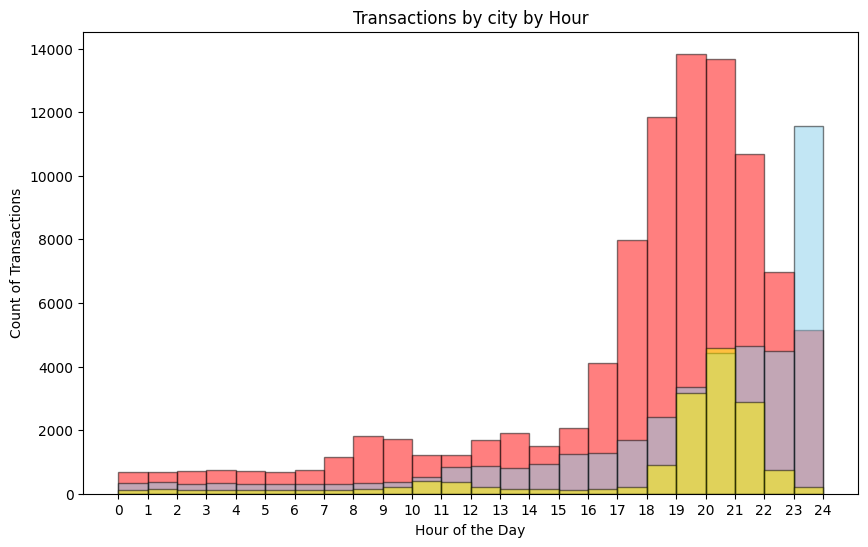

In [141]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df[df['city']=='Toronto']['timestamp'].dt.hour, bins=24, range=(0, 24), color='red', edgecolor='black', alpha=0.5)
plt.hist(df[df['city']=='Vancouver']['timestamp'].dt.hour, bins=24, range=(0, 24), color='skyblue', edgecolor='black', alpha=0.5)
plt.hist(df[df['city']=='Calgary']['timestamp'].dt.hour, bins=24, range=(0, 24), color='yellow', edgecolor='black', alpha=0.5)
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Transactions')
plt.title('Transactions by city by Hour')
plt.xticks(range(0, 25))
plt.show()

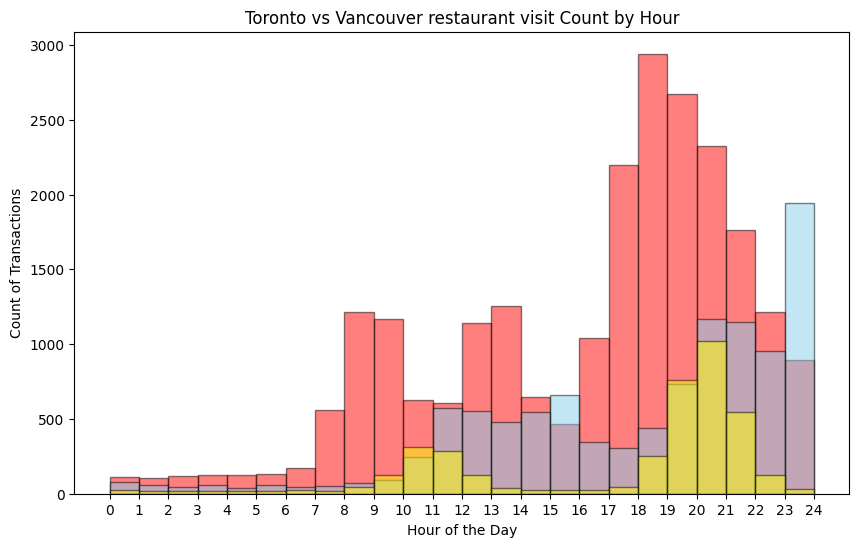

In [142]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df[(df['city']=='Toronto')&(df['merchant_type']=='Restaurant')]['timestamp'].dt.hour, bins=24, range=(0, 24), color='red', edgecolor='black', alpha=0.5)
plt.hist(df[(df['city']=='Vancouver')&(df['merchant_type']=='Restaurant')]['timestamp'].dt.hour, bins=24, range=(0, 24), color='skyblue', edgecolor='black', alpha=0.5)
plt.hist(df[(df['city']=='Calgary')&(df['merchant_type']=='Restaurant')]['timestamp'].dt.hour, bins=24, range=(0, 24), color='yellow', edgecolor='black', alpha=0.5)
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Transactions')
plt.title('Toronto vs Vancouver restaurant visit Count by Hour')
plt.xticks(range(0, 25))
plt.show()

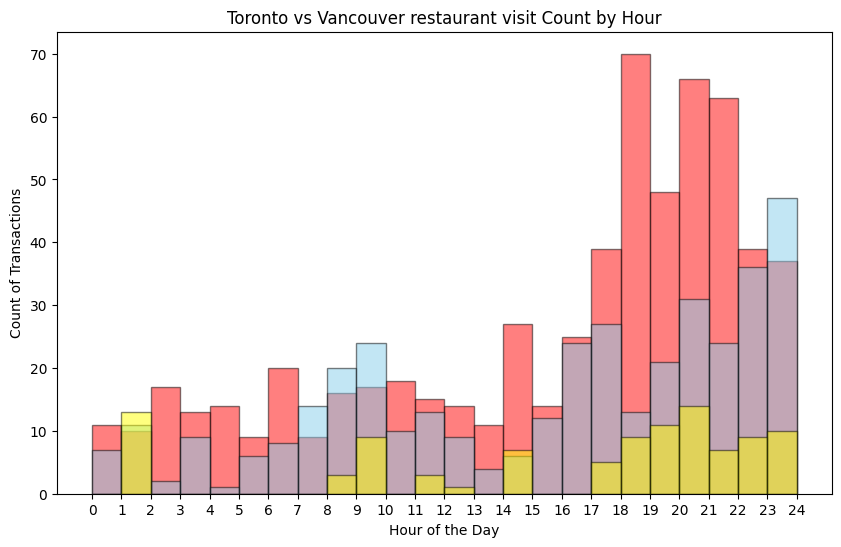

In [143]:
plt.figure(figsize=(10, 6))
plt.hist(df[(df['city']=='Toronto')&(df['Fraud_Label']==1)]['timestamp'].dt.hour, bins=24, range=(0, 24), color='red', edgecolor='black', alpha=0.5)
plt.hist(df[(df['city']=='Vancouver')&(df['Fraud_Label']==1)]['timestamp'].dt.hour, bins=24, range=(0, 24), color='skyblue', edgecolor='black', alpha=0.5)
plt.hist(df[(df['city']=='Calgary')&(df['Fraud_Label']==1)]['timestamp'].dt.hour, bins=24, range=(0, 24), color='yellow', edgecolor='black', alpha=0.5)
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Transactions')
plt.title('Toronto vs Vancouver restaurant visit Count by Hour')
plt.xticks(range(0, 25))
plt.show()

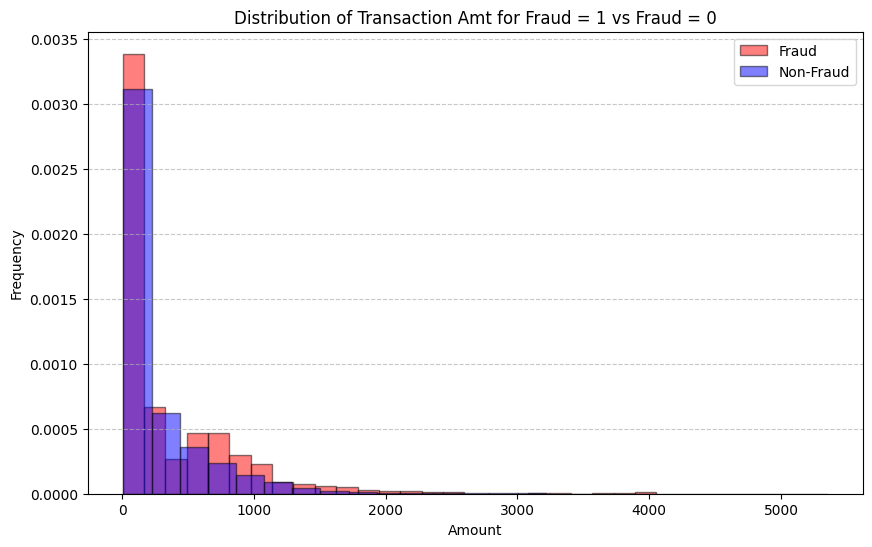

In [144]:

B_A1 = df[df['Fraud_Label'] == 1]['transaction_amount']
B_A0 = df[df['Fraud_Label'] == 0]['transaction_amount']

# Define bin edges
bins = np.linspace(min(df['transaction_amount']), max(df['transaction_amount']), 10)

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(B_A1, bins=25, color='red', alpha=0.5, label='Fraud', edgecolor='black', density=True)
plt.hist(B_A0, bins=25, color='blue', alpha=0.5, label='Non-Fraud', edgecolor='black', density=True)

# Labels and title
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.title("Distribution of Transaction Amt for Fraud = 1 vs Fraud = 0")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

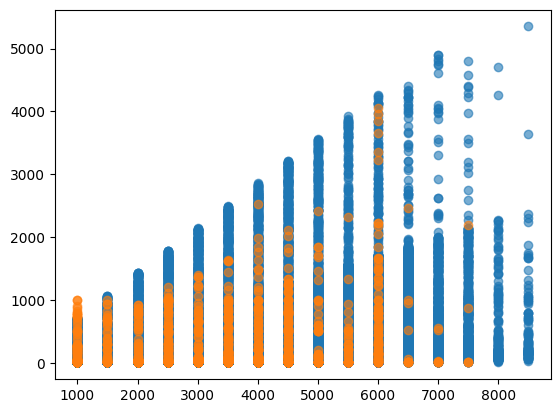

In [145]:
# Get unique values in the color column
unique_colors = df['Fraud_Label'].unique()
    
# Create scatter plot for each unique value in col_color
for color_val in unique_colors:
    # Filter data for this color value
    subset = df[df['Fraud_Label'] == color_val]
    # Plot points with label for legend
    plt.scatter(subset['credit_limit'], subset['transaction_amount'], 
                   label=str(color_val), 
                   alpha=0.6)